In [1]:
from keras.layers import Input, Dense, LeakyReLU, Activation, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Generator

In [2]:
z_dim = 100
target_size = (128, 128)

n_f_maps_G =    [100, 2048 , 1024 , 512 ,  256 , 128 ,   3 ]
size_f_maps_G = [ 1  ,  4  ,    8 ,  16 ,   32 ,  64 , 128 ]   

In [3]:
input_generator = Input(shape=(z_dim,))
x = Reshape((1,1,z_dim))(input_generator)
x = Conv2DTranspose(filters=2048, padding='valid', kernel_size=4, strides=1, use_bias=False)(x)
print(x)

Tensor("conv2d_transpose_1/conv2d_transpose:0", shape=(?, ?, ?, 2048), dtype=float32)


In [4]:
for i in range(2, len(n_f_maps_G) - 1):
    x = Conv2DTranspose(filters=n_f_maps_G[i], padding='same', kernel_size=4, strides=2, use_bias=False)(x)
    x = Activation('selu')(x)

In [5]:
# final transposed conv 
x = Conv2DTranspose(filters=n_f_maps_G[-1], padding='same', kernel_size=4, strides=2, use_bias=False)(x)
output_generator = Activation("tanh")(x)

In [6]:
generator = Model(inputs=input_generator, outputs=output_generator)
generator.compile(loss='binary_crossentropy', optimizer="adam")
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 2048)        3276800   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 1024)        33554432  
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 512)       8388608   
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 512)       0         
__________

# Discriminator

In [7]:
n_f_maps_D =    [   3 , 128 , 256 , 512 , 1024 , 2018 ]
size_f_maps_D = [ 128 ,  64 ,  32 ,  16 ,    8 ,    4 ]

In [8]:
input_discriminator = Input(shape=target_size+(3,))
x = Conv2D(filters=n_f_maps_D[1], kernel_size=4, padding='same', strides=2, use_bias=False)(input_discriminator)
x = Activation("selu")(x)
print(x)

Tensor("activation_6/mul_1:0", shape=(?, 64, 64, 128), dtype=float32)


In [9]:
for i in range(2, len(n_f_maps_D)):
    x = Conv2D(filters=n_f_maps_D[i], padding='same', kernel_size=4, strides=2, use_bias=False)(x)
    x = Activation("selu")(x)
print(x)

Tensor("activation_10/mul_1:0", shape=(?, 4, 4, 2018), dtype=float32)


In [10]:
x = Conv2D(filters=1, activation='sigmoid', use_bias=False, padding='valid', kernel_size=4)(x)
print(x)
output_discriminator = Flatten()(x)
print(output_discriminator)

Tensor("conv2d_6/Sigmoid:0", shape=(?, 1, 1, 1), dtype=float32)
Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)


In [11]:
discriminator = Model(inputs=input_discriminator, outputs=output_discriminator)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       6144      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524288    
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       2097152   
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 512)       0         
__________

In [12]:
opt = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999)
discriminator.compile(optimizer=opt,
                      loss='binary_crossentropy')

## Combine G + D to get the adversarial loss 

In [13]:
discriminator.trainable = False

input_gan = Input(shape=(z_dim,))
output_gan = discriminator(generator(input_gan))

gan = Model(inputs=input_gan, outputs=output_gan)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       47847424  
_________________________________________________________________
model_2 (Model)              (None, 1)                 44111392  
Total params: 91,958,816
Trainable params: 47,847,424
Non-trainable params: 44,111,392
_________________________________________________________________


In [14]:
opt = Adam(lr=2e-4, beta_1=0.5, beta_2=0.999)
gan.compile(optimizer=opt,
            loss='binary_crossentropy')

In [15]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       6144      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524288    
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       2097152   
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 512)       0         
__________

# Launch the training

In [40]:
z_test = np.random.normal(size=(4, z_dim))

In [46]:
#discriminator.load_weights('../checkpoints/meow_generator/exp2/discriminator_7500.h5')
generator.load_weights('../checkpoints/meow_generator/exp2/generator_7500.h5')

In [47]:
generated_imges = generator.predict(z_test)
generated_imges = np.clip((generated_imges + 1.)*127.5, 0, 255).astype(np.uint8)

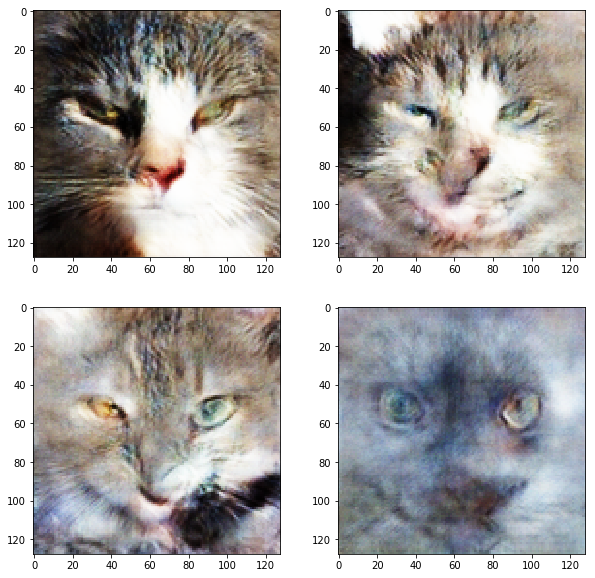

In [48]:
fig, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)
axes[0,0].imshow(generated_imges[0])
axes[0,1].imshow(generated_imges[1])
axes[1,0].imshow(generated_imges[2])
axes[1,1].imshow(generated_imges[3])

In [20]:
from gan_utils import BatchGenerator

In [21]:
batch_size = 128
nb_epochs = 1000
k = 1 # assymetric training
dataset_dir = '../data/cat_dataset/'

batch_gen = BatchGenerator(directory=dataset_dir, batch_size=batch_size, target_size=target_size, pre_processing='tf')

Found 6444 images


In [22]:
nb_steps_per_epoch = batch_gen.samples // batch_size
print(nb_steps_per_epoch)

50


In [23]:
i = 0

In [40]:
for epoch in range(nb_epochs):
    
    for step in range(nb_steps_per_epoch):
        ###################################### TRAIN THE DISCRIMINATOR ###############################
        discriminator.trainable = True
        # generate fake images
        random_z_vectors = np.random.normal(size=(batch_size, z_dim))
        fake_images = generator.predict(random_z_vectors)
        labels = 0.9*np.ones((batch_size, 1), dtype=np.float32)
        d_loss_1 = discriminator.train_on_batch(fake_images, labels)
        
        
        # get real images
        real_images = batch_gen.next()
        labels = 0.05*np.ones((batch_size, 1), dtype=np.float32)
        d_loss_2 = discriminator.train_on_batch(real_images, labels)
        
       
        # ############################################################################################
        
        ###################################### TRAIN THE GENERATOR ###################################
        discriminator.trainable = False
        random_z_vectors = np.random.normal(size=(batch_size, z_dim))
        misleading_labels = np.zeros((batch_size, 1))
        g_loss = gan.train_on_batch(random_z_vectors, misleading_labels)
        
        ###############################################################################################
        i +=1
        if i % 50 == 0:
            print("At {} iteration : ".format(i))
            print('\tdiscriminator loss: {}'.format((d_loss_1, d_loss_2)))
            print('\tgenerator loss:  {}'.format(g_loss))
        
        if i%500 == 0:
            print("Save weights at {} .... ".format(i))
            discriminator.save_weights("../checkpoints/meow_generator/exp2/discriminator_{}.h5".format(i))
            generator.save_weights("../checkpoints/meow_generator/exp2/generator_{}.h5".format(i))

At 50 iteration : 
	discriminator loss: (0.4893195, 0.4243154)
	generator loss:  1.9574735164642334
At 100 iteration : 
	discriminator loss: (0.63029325, 0.5814738)
	generator loss:  1.7003798484802246
At 150 iteration : 
	discriminator loss: (0.79015315, 0.6823894)
	generator loss:  1.7855952978134155
At 200 iteration : 
	discriminator loss: (0.50560397, 0.46849102)
	generator loss:  1.8309736251831055
At 250 iteration : 
	discriminator loss: (1.0139477, 0.71110016)
	generator loss:  2.239398717880249
At 300 iteration : 
	discriminator loss: (0.5616454, 0.47477123)
	generator loss:  1.5868252515792847
At 350 iteration : 
	discriminator loss: (0.66020274, 0.61237574)
	generator loss:  1.7899258136749268
At 400 iteration : 
	discriminator loss: (0.58758104, 0.54243577)
	generator loss:  1.686529278755188
At 450 iteration : 
	discriminator loss: (0.58655876, 0.414489)
	generator loss:  2.150779962539673
At 500 iteration : 
	discriminator loss: (0.47769302, 0.49640003)
	generator loss:  1

KeyboardInterrupt: 

In [ ]:
discriminator.trainable = True
for i in range(100):
    random_z_vectors = np.random.normal(size=(batch_size, z_dim))
    fake_images = generator.predict(random_z_vectors)
    labels = 0.9*np.ones((batch_size, 1))
    d_loss_1 = discriminator.train_on_batch(fake_images, labels)


            # get real images
    real_images = batch_gen.next()
    labels = 0.1*np.ones((batch_size, 1))
    d_loss_2 = discriminator.train_on_batch(real_images, labels)
    print('\tdiscriminator loss: {}'.format((d_loss_1, d_loss_2)))

In [49]:
discriminator.trainable = False
for i in range(10):
    random_z_vectors = np.random.normal(size=(batch_size, z_dim))
    misleading_labels = np.zeros((batch_size, 1))
    g_loss = gan.train_on_batch(random_z_vectors, misleading_labels)
    print('\tgenerator loss:  {}'.format(g_loss))

	generator loss:  0.23147937655448914
	generator loss:  0.11538277566432953
	generator loss:  0.10574882477521896
	generator loss:  0.0971897765994072
	generator loss:  0.031791046261787415
	generator loss:  0.04365197941660881
	generator loss:  0.04630022495985031
	generator loss:  0.052135154604911804
	generator loss:  0.039480339735746384
	generator loss:  0.029619144275784492
